In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import desc
from pyspark.sql.types import DecimalType, FloatType
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt 
import geopandas
import geoplot
from pyproj import CRS
import pandas_bokeh
pandas_bokeh.output_notebook()
import seaborn as sns
sns.set()

Loading BokehJS ...

In [ ]:
#hello world 

### Import the data to Spark

In [2]:
spark = SparkSession.builder.appName("COVID").config("spark.some.config.option", "some-value").getOrCreate()
confirmed = spark.read.csv('time_series_19-covid-Confirmed_archived_0325.csv', header=True, inferSchema = True)

# I will start by creating temporary table querying with SQL
confirmed.createOrReplaceTempView('COVID_Confirmed')
sparkConfirmedDF = spark.sql('''SELECT * FROM COVID_Confirmed''')

### Preprocess the data

###### Handle null values & Select only the relevant rows (i.e., those that include data about Australia)

In [3]:
# Handling (Dropping) 'NULL / None' Values
ConfirmedDF = sparkConfirmedDF.na.drop()

# Selecting Australia Confirmed Cases
confirmed = spark.sql('''
SELECT * FROM COVID_Confirmed 
WHERE `Country/Region` = 'Australia'
''')
confirmed.show()

+--------------------+--------------+--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Province/State|Country/Region|     Lat|    Long|1/22/20|1/23/20|1/24/20|1/25/20|1/26/20|1/27/20|1/28/20|1/29/20|1/30/20|1/31/20|2/1/20|2/2/20|2/3/20|2/4/20|2/5/20|2/6/20|2/7/20|2/8/20|2/9/20|2/10/20|2/11/20|2/12/20|2/13/20|2/14/20|2/15/20|2/16/20|2/17/20|2/18/20|2/19/20|2/20/20|2/21/20|2/22/20|2/23/20|2/24/20|2/25/20|2/26/20|2/27/20|2/28/20|2/29/20|3/1/20|3/2/20|3/3/20|3/4/20|3/5/20|3/6/20|3/7/20|3/8/20|3/9/20|3/10/20|3/11/20|3/12/20|3/13/20|3/14/20|3/15/

In [4]:
# show data in visualisation
confirmed2=confirmed.toPandas()
confirmed2.plot_bokeh(kind='bar', x='Province/State', y = list(confirmed2.columns.values),
              xlabel='Provinces / States', ylabel='Frequency', 
              legend=False, title='Frequency by Days', figsize=(1000, 500))

Figure(id='1038', ...)

In [5]:
gpdf = geopandas.GeoDataFrame(confirmed2, geometry=geopandas.points_from_xy(confirmed2.Long, confirmed2.Lat))
gpdf.crs = CRS.from_string("epsg:4326")
gpdf.plot_bokeh(legend=False)

Figure(id='2143', ...)

In [6]:
columns_to_select = confirmed.columns[14:]
# Selecting a subset from the dataframe
confirmed = confirmed.select(columns_to_select)

In [7]:
# sum up all rows data into 1 row (merging)
confirmed = confirmed.select(confirmed.columns).groupBy().sum()

###### Merge the data to one row since we want to consider the entire Australia

In [8]:
# sum up all rows data into 1 row (merging)
confirmed = confirmed.select(confirmed.columns).groupBy().sum()

# renaming column names for indexing
counter = 0
for column in confirmed.columns:
    confirmed = confirmed.withColumnRenamed(f"{column}", f"{counter}")
    counter = counter + 1
    
# Converting to Pandas to transpose the dataframe
confirmed_transpose = confirmed.toPandas().transpose()
confirmed_transpose

,0
0,12
1,12
2,12
3,13
4,13
5,14
6,15
7,15
8,15
9,15


In [9]:
# Creating a Spark DataFrame from our Pandas DataFrame
confirmedSparkDF = spark.createDataFrame(confirmed_transpose)
confirmedSparkDF = confirmedSparkDF.withColumnRenamed(f"{0}", "total_counts")
confirmedSparkDF = confirmedSparkDF.withColumn("indexes", F.row_number()
                                               .over(Window.orderBy(F.monotonically_increasing_id())) - 1)
confirmedSparkDF.show()

+------------+-------+
|total_counts|indexes|
+------------+-------+
|          12|      0|
|          12|      1|
|          12|      2|
|          13|      3|
|          13|      4|
|          14|      5|
|          15|      6|
|          15|      7|
|          15|      8|
|          15|      9|
|          15|     10|
|          15|     11|
|          15|     12|
|          15|     13|
|          15|     14|
|          15|     15|
|          15|     16|
|          15|     17|
|          15|     18|
|          15|     19|
+------------+-------+
only showing top 20 rows



In [10]:
featureassembler = VectorAssembler(inputCols = ['indexes'], outputCol="Days")
output = featureassembler.transform(confirmedSparkDF)
finalized_data = output.select("Days", "total_counts")

###### Splitting into Train & Test data

In [11]:
finalized_data.createOrReplaceTempView("Finalized_Cases")
train_data = spark.sql("SELECT * FROM Finalized_Cases LIMIT 50")
test_data = spark.sql("SELECT * FROM Finalized_Cases ORDER BY Days DESC LIMIT 2")

#####  Alternate method to split data into train and test data  ######
# train_data = finalized_data.where(F.col('indexes') < 50)
# test_data = finalized_data.where(F.col('indexes') > 49)

train_data.show()
test_data.show()

+------+------------+
|  Days|total_counts|
+------+------------+
| [0.0]|          12|
| [1.0]|          12|
| [2.0]|          12|
| [3.0]|          13|
| [4.0]|          13|
| [5.0]|          14|
| [6.0]|          15|
| [7.0]|          15|
| [8.0]|          15|
| [9.0]|          15|
|[10.0]|          15|
|[11.0]|          15|
|[12.0]|          15|
|[13.0]|          15|
|[14.0]|          15|
|[15.0]|          15|
|[16.0]|          15|
|[17.0]|          15|
|[18.0]|          15|
|[19.0]|          15|
+------+------------+
only showing top 20 rows

+------+------------+
|  Days|total_counts|
+------+------------+
|[51.0]|        1314|
|[50.0]|        1314|
+------+------------+



In [12]:
# plotting the data
#finalized_data.toPandas().drop(['Days'],axis=1).plot(kind='line',figsize=(10,5))
finalized_data.toPandas().plot_bokeh(kind='line', legend=False, figsize=(1000, 500))

Figure(id='2268', ...)

### Apply Regression Method

In [13]:
regressor = LinearRegression(featuresCol='Days', labelCol='total_counts', maxIter=10, regParam=0.8, elasticNetParam=0.5)
regressor = regressor.fit(train_data)

print('Regressor coefficient: ', regressor.coefficients)
print('Regressor intercept: ', regressor.intercept)
Summary = regressor.summary
print("total Iterations: %d" % Summary.totalIterations)
print("RMSE: %f" % Summary.rootMeanSquaredError)
print("R-squared: %f" % Summary.r2)
train_data.describe().show()

Regressor coefficient:  [10.308381899055645]
Regressor intercept:  -131.9753565268633
total Iterations: 3
RMSE: 163.472712
R-squared: 0.455198
+-------+------------------+
|summary|      total_counts|
+-------+------------------+
|  count|                50|
|   mean|            120.58|
| stddev|223.72423714411073|
|    min|                12|
|    max|              1071|
+-------+------------------+



In [14]:
pred_results = regressor.evaluate(test_data)
test_data = pred_results.predictions
test_data.show()

+------+------------+-----------------+
|  Days|total_counts|       prediction|
+------+------------+-----------------+
|[51.0]|        1314|393.7521203249746|
|[50.0]|        1314|383.4437384259189|
+------+------------+-----------------+



### Compute the Difference

In [15]:
prediction = pred_results.predictions.select("prediction").collect()
test_data_actual = test_data.withColumnRenamed("total_counts","actual")
test_data_actual = test_data_actual.select("actual").collect()

actual_cases = []
predicted_cases = []
for actual in test_data_actual:
    actual_cases.append(float(actual.actual))  
for predicts in prediction:
    predicted_cases.append(predicts.prediction)
    
difference = [actual - predicted for actual, predicted in zip(actual_cases, predicted_cases)]
differenceDF = spark.createDataFrame(difference, FloatType())
differenceDF = differenceDF.withColumnRenamed("value","difference_values")
differenceDF.show()

+-----------------+
|difference_values|
+-----------------+
|        920.24786|
|         930.5563|
+-----------------+



### Visualizing Results

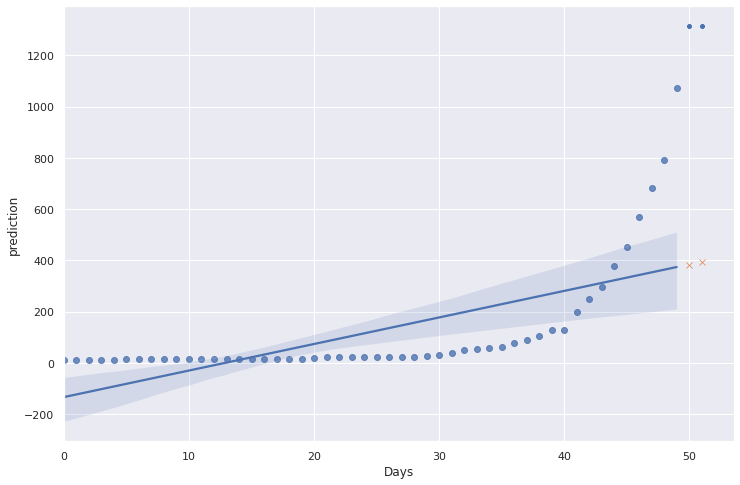

In [16]:
actual_DF = output.select("indexes", "total_counts").withColumnRenamed(f"indexes", "Days")

# Converting to Pandas to plot scatter and regression plots
actual_data = actual_DF.toPandas()
Predicted_df = test_data.toPandas()

Predicted_df['Days']=[51,50]
f, ax = plt.subplots(figsize=(12,8))
sns.regplot(x='Days',y='total_counts',data=actual_data[:-2])
sns.scatterplot(x='Days',y='total_counts',data=Predicted_df)
sns.scatterplot(x='Days',y='prediction',data=Predicted_df,marker='x')

In [ ]:
# create residual plot
f, ax = plt.subplots(figsize=(12, 8))
sns.residplot(x='Days',y='total_counts',data=actual_data[:-2])
sns.scatterplot(x=[51,50],y='difference_values',data=differenceDF.toPandas(),marker='x')

In [ ]:
#End